## Integrative Multi-Omics Analysis of TCGA Breast Cancer: Constructing Gene–Gene Associations Using LASSO

### Introduction

Understanding the regulatory relationships between DNA methylation and gene expression is critical for uncovering molecular mechanisms in cancer. Multi-omics integration allows researchers to link epigenetic modifications with transcriptional activity, providing insights into gene regulation and potential therapeutic targets.

This project focuses on TCGA breast cancer (TCGA-BRCA) data, combining RNA-seq gene expression and DNA methylation profiles. The pipeline includes data retrieval from the GDC API, preprocessing, and construction of a gene–gene association network using LASSO regression. The resulting network highlights significant methylation–expression relationships, demonstrating how computational approaches can reveal complex biological interactions

This work was developed by adapting an exercise from the Coursera course *Introduction to Bioinformatics* offered by the Birla Institute of Technology & Science (BITS), Pilani.

### Load Required Libraries

This cell imports the core Python libraries used throughout the project.  
- `requests` is used to communicate with the TCGA/GDC REST API and download data programmatically.  
- `pandas` is used for data manipulation, cleaning, and tabular data storage.  
- `zipfile` and `BytesIO` are used to handle compressed files downloaded from GDC.  
- `StringIO` enables parsing text-based data directly from memory without saving intermediate files.

In [1]:
# Load libraries
import requests  
import pandas as pd  
import zipfile 
from io import BytesIO, StringIO  

### Download Clinical Metadata from TCGA (GDC)
 A function is defined that queries the GDC *cases* endpoint to retrieve clinical and demographic information for a specified TCGA project. The request filters cases by project ID and selects relevant patient-level variables such as demographics, tumor stage, survival status, follow-up time, and exposure history.

The returned TSV data are converted into a structured Pandas DataFrame, standardized with readable column names, and saved as a CSV file for downstream analysis. The function also extracts and returns a list of unique sample barcodes, which are later used to link clinical data with multi-omics datasets.


In [2]:
def download_clinical_data(project_id="TCGA-BRCA", output_csv="Data_Downlaod/patients.csv"):
    """
    Downloads clinical data for a TCGA project, saves to 'patients.csv',
    and returns a list of sample barcodes.
    """
    base_url = "https://api.gdc.cancer.gov/cases"

    params = {
        "filters": {
            "op": "and",
            "content": [
                {
                    "op": "=",
                    "content": {
                        "field": "cases.project.project_id",
                        "value": project_id
                    }
                }
            ]
        },
        "fields": (
            "case_id,"
            "submitter_id,"
            "demographic.gender,"
            "demographic.race,"
            "demographic.ethnicity,"
            "diagnoses.tumor_stage,"
            "diagnoses.vital_status,"
            "diagnoses.days_to_death,"
            "diagnoses.days_to_last_follow_up,"
            "exposures.alcohol_history,"
            "exposures.smoking_history"
        ),
        "format": "TSV",
        "size": 10000
    }

    response = requests.post(base_url, json=params)
    if response.status_code == 200:
        tsv_file = "Data_Downlaod/clinical_temp.tsv"
        with open(tsv_file, "wb") as f:
            f.write(response.content)

        df = pd.read_csv(tsv_file, sep="\t")
        df = df.rename(columns={
            "case_id": "Case_ID",
            "submitter_id": "Barcode",
            "demographic.gender": "Gender",
            "demographic.race": "Race",
            "demographic.ethnicity": "Ethnicity",
            "diagnoses.tumor_stage": "Tumor_Stage",
            "diagnoses.vital_status": "Vital_Status",
            "diagnoses.days_to_death": "Days_to_Death",
            "diagnoses.days_to_last_follow_up": "Days_to_Last_FollowUp",
            "exposures.alcohol_history": "Alcohol_History",
            "exposures.smoking_history": "Smoking_History"
        })

        df.to_csv(output_csv, index=False)
        print(f"Clinical data saved to '{output_csv}'")

        barcodes = df["Barcode"].dropna().unique().tolist()
        return barcodes
    else:
        print(f"Error {response.status_code} downloading clinical data.")
        print(response.text)
        return []

### Retrieve File Metadata for a Sample

It defines a helper function that queries the GDC *files* endpoint to obtain metadata for all data files associated with a given TCGA sample barcode. The function allows flexible selection of metadata fields such as file ID, file name, data category, and data type.

The returned metadata are used to identify and filter relevant omics files (e.g., RNA-seq or DNA methylation) before downloading the actual data files. If the request fails, an empty list is returned and the error is reported.


In [3]:
def fetch_file_metadata(barcode, fields=None, size=1000):
    """
    For a given sample barcode, queries the GDC 'files' endpoint
    to retrieve file metadata hits.
    """
    if fields is None:
        fields = ["file_id","file_name","data_category","data_type"]
    fields_str = ",".join(fields)

    query = {
        "filters": {
            "op": "in",
            "content": {
                "field": "cases.submitter_id",
                "value": [barcode]
            }
        },
        "fields": fields_str,
        "size": size
    }

    resp = requests.post("https://api.gdc.cancer.gov/files", json=query)
    if resp.status_code == 200:
        return resp.json().get("data", {}).get("hits", [])
    else:
        print(f"Error fetching metadata for {barcode}: {resp.status_code}")
        return []


### Parse RNA-seq Gene Expression Files (FPKM)

Defines a parser for TCGA RNA-seq gene expression files containing FPKM values. The function decodes the downloaded file, removes comment lines if present, and reads the tab-delimited data into a Pandas DataFrame.

Only the biologically relevant columns (`gene_id` and `fpkm_unstranded`) are retained. Gene identifiers are set as row indices, and expression values are labeled using the corresponding sample barcode. The output is a single-column DataFrame suitable for merging across multiple samples.

In [4]:
def parse_gdc_file_expr_fpkm(content_bytes, barcode, encoding="utf-8"):
    """
    Skips a '#' line if present, then expects a header with columns
    including 'gene_id' and 'fpkm_unstranded'. Keeps just those two,
    renaming 'gene_id' -> 'ID' and 'fpkm_unstranded' -> <barcode>.
    Returns a DataFrame: rows=gene_id, single col=[<barcode>].
    """
    raw_text = content_bytes.decode(encoding, errors="replace")
    lines = raw_text.splitlines()
    # if top line starts with '#', skip it
    if lines and lines[0].startswith("#"):
        lines = lines[1:]

    from io import StringIO
    df = pd.read_csv(
        StringIO("\n".join(lines)),
        sep="\t",
        header=0
    )
    if df.empty:
        return None

    # skip alignment summary rows if you like, e.g. df = df[~df['gene_id'].str.startswith("N_")]

    if 'gene_id' not in df.columns or 'fpkm_unstranded' not in df.columns:
        print("Skipping file: Missing 'gene_id' or 'fpkm_unstranded' columns.")
        return None

    df = df[['gene_id','fpkm_unstranded']]  # just two columns

    # rename
    df = df.rename(columns={'gene_id': 'ID', 'fpkm_unstranded': barcode})
    df = df.set_index('ID')

    return df

### Parse DNA Methylation Beta Value Files

A parser is defined for TCGA DNA methylation data files, which typically contain probe identifiers and corresponding beta values without a header. Comment lines are removed if present, and the remaining data are read as a two-column table.

Probe IDs are used as row indices, while beta values are labeled with the sample barcode. The resulting single-column DataFrame enables straightforward merging of methylation profiles across multiple samples.


In [5]:
def parse_gdc_file_meth(content_bytes, barcode, encoding="utf-8"):
    """
    If top line starts with '#', skip it.
    Then we parse as no header => header=None,
    names=["probe_id","beta_value"].

    rename => [ID, <barcode>], index=ID => single-col DF
    """
    raw_text = content_bytes.decode(encoding, errors="replace")
    lines = raw_text.splitlines()
    if lines and lines[0].startswith("#"):
        lines = lines[1:]  # skip top comment line

    from io import StringIO
    df = pd.read_csv(
        StringIO("\n".join(lines)),
        sep="\t",
        header=None,
        names=["probe_id","beta_value"],
        na_values=["NA","N/A"]
    )
    if df.empty:
        return None

    df = df.rename(columns={"probe_id": "ID", "beta_value": barcode})
    df = df.set_index("ID")
    return df

### Download and Construct RNA-seq Gene Expression Matrix (FPKM)

Implements an automated pipeline to retrieve RNA-seq gene expression data for multiple TCGA samples. For each sample barcode, the function identifies transcriptome profiling files with FPKM-based quantification, downloads the corresponding files, and handles both compressed and uncompressed formats.

Gene-level expression values (`fpkm_unstranded`) are parsed and merged across samples into a unified matrix. Duplicate files per sample are skipped to ensure one expression profile per barcode. The final matrix is transposed to a standard **samples × genes** format and saved as a CSV file for downstream multi-omics analysis.

In [6]:
def download_and_merge_expression_fpkm(
    barcodes,
    data_category="Transcriptome Profiling",
    data_types=None,
    encoding="utf-8",
    output_csv="Data_Downlaod/gene_expression_fpkm.csv"
):
    """
    For each barcode, fetch gene expression files, parse only [gene_id,fpkm_unstranded].
    Merge => row=gene_id, col=barcode. Then transpose => row=barcode, col=gene_id.
    """
 
    if data_types is None:
        data_types = ["Gene Expression Quantification","HTSeq - FPKM","HTSeq - FPKM-UQ"]
    dt_lc = [x.lower() for x in data_types]

    merged_df = None
    text_exts = (".txt",".tsv",".txt.gz",".tsv.gz")

    # Track if we already got a file for a sample to skip duplicates
    barcodes_done = set()

    for bcode in barcodes:
        hits = fetch_file_metadata(bcode)
        if not hits:
            continue

        for h in hits:
            cat   = h.get("data_category","").lower()
            dtype = h.get("data_type","").lower()
            fname = h.get("file_name","").lower()
            fid   = h.get("file_id")

            if cat != data_category.lower() or dtype not in dt_lc:
                continue

            if bcode in barcodes_done:
                print(f"Already have gene expression for {bcode}, skipping duplicates.")
                continue

            if not any(fname.endswith(ext) for ext in text_exts):
                print(f"Skipping {fname} for {bcode}, likely binary.")
                continue

            # Download
            file_url = f"https://api.gdc.cancer.gov/data/{fid}"
            resp = requests.get(file_url)
            if resp.status_code != 200:
                print(f"Error fetching {fid} for {bcode}: {resp.status_code}")
                continue

            file_bytes = resp.content

            # Attempt zip parse
            from io import BytesIO
            try:
                with zipfile.ZipFile(BytesIO(file_bytes)) as zf:
                    for zname in zf.namelist():
                        with zf.open(zname) as zsub:
                            sub_bytes = zsub.read()
                            df_sub = parse_gdc_file_expr_fpkm(sub_bytes, bcode, encoding)
                            if df_sub is not None:
                                if merged_df is None:
                                    merged_df = df_sub
                                else:
                                    merged_df = merged_df.join(df_sub, how="outer", lsuffix="_old", rsuffix="_new")
                                barcodes_done.add(bcode)
                                print(f"Parsed sub-file {zname} for {bcode}")
            except zipfile.BadZipFile:
                # Not zip => parse directly
                df_one = parse_gdc_file_expr_fpkm(file_bytes, bcode, encoding)
                if df_one is not None:
                    if merged_df is None:
                        merged_df = df_one
                    else:
                        merged_df = merged_df.join(df_one, how="outer", lsuffix="_old", rsuffix="_new")
                    barcodes_done.add(bcode)
                print(f"Parsed {fname} for {bcode}")

    if merged_df is None:
        print("No fpkm_unstranded data found. Gene expression matrix is empty.")
        return None

    # transpose => rows=barcodes, columns=gene_id
    merged_df = merged_df.T

    merged_df.to_csv(output_csv)
    print(f"Gene expression (fpkm) saved to '{output_csv}'")
    return merged_df

### Download and Construct DNA Methylation Matrix

Implements a workflow to retrieve DNA methylation beta value data for multiple TCGA samples. For each sample barcode, the function identifies relevant methylation files, downloads the data, and supports both compressed and uncompressed formats.

Probe-level beta values are parsed and merged across samples into a unified matrix while ensuring that duplicate files per sample are ignored. The resulting matrix is transposed into a **samples × probes** format and saved as a CSV file, enabling integration with gene expression data in downstream analyses.

In [ ]:
#Download & Merge DNA Methylation => numeric matrix
def download_and_merge_methylation(
    barcodes,
    data_category="DNA Methylation",
    data_types=None,
    encoding="utf-8",
    output_csv="Data_Downlaod/dna_methylation_numeric.csv"
):
    """
    For each sample, find DNA Methylation files, parse 2-col data [probe,beta_value].
    Merge => row=probe, col=barcode, then transpose => row=barcode, col=probe.

    Skips duplicates if multiple files exist for the same sample.
    """
    if data_types is None:
        data_types = ["Methylation Beta Value"]
    dt_lc = [x.lower() for x in data_types]

    merged_df = None
    text_exts = (".txt",".tsv",".txt.gz",".tsv.gz")

    barcodes_done = set()

    for bcode in barcodes:
        hits = fetch_file_metadata(bcode)
        if not hits:
            continue

        for h in hits:
            cat   = h.get("data_category","").lower()
            dtype = h.get("data_type","").lower()
            fname = h.get("file_name","").lower()
            fid   = h.get("file_id")

            if cat != data_category.lower() or dtype not in dt_lc:
                continue
                print(barcodes_done)

            if bcode in barcodes_done:

                print(bcode)
                print(f"Already have DNA methylation for {bcode}, skipping duplicates.")
                continue

            if not any(fname.endswith(ext) for ext in text_exts):
                print(f"Skipping {fname} for {bcode}, likely binary.")
                continue

            # Download
            file_url = f"https://api.gdc.cancer.gov/data/{fid}"
            resp = requests.get(file_url)
            if resp.status_code != 200:
                print(f"Error fetching {fid} for {bcode}: {resp.status_code}")
                continue

            file_bytes = resp.content

            # Attempt zip parse
            from io import BytesIO
            try:
                with zipfile.ZipFile(BytesIO(file_bytes)) as zf:
                    for zname in zf.namelist():
                        with zf.open(zname) as zsub:
                            sub_bytes = zsub.read()
                            df_sub = parse_gdc_file_meth(sub_bytes, bcode, encoding)
                            if df_sub is not None:
                                if merged_df is None:
                                    merged_df = df_sub
                                else:
                                    merged_df = merged_df.join(df_sub, how="outer", lsuffix="_old", rsuffix="_new")
                                barcodes_done.add(bcode)
                                print(f"Parsed sub-file {zname} for {bcode}")
            except zipfile.BadZipFile:
                # not a zip => parse directly
                df_one = parse_gdc_file_meth(file_bytes, bcode, encoding)
                if df_one is not None:
                    if merged_df is None:
                        merged_df = df_one
                    else:
                        merged_df = merged_df.join(df_one, how="outer", lsuffix="_old", rsuffix="_new")
                    barcodes_done.add(bcode)
                print(f"Parsed {fname} for {bcode}")

    if merged_df is None:
        print("No DNA Methylation data found. Methylation matrix is empty.")
        return None

    # transpose => rows=barcodes, columns=probe
    merged_df = merged_df.T

    merged_df.to_csv(output_csv)
    print(f"DNA Methylation numeric matrix saved to '{output_csv}'")
    return merged_df

### Download Clinical Data and Extract Sample Barcodes

It is time to specify the TCGA breast cancer project (TCGA-BRCA) and download the corresponding clinical metadata. The clinical information is saved as a CSV file, and the associated sample barcodes are extracted for use in downloading and integrating matched omics datasets.


In [ ]:
# 1) Download clinical data => 'patients.csv'
project_id = "TCGA-BRCA"
barcodes = download_clinical_data(project_id, output_csv="Data_Download/patients.csv")

Clinical data saved to 'Data_Downlaod/patients.csv'


### Select a Subset of Samples for Analysis

It it time to restrict the analysis to a small subset of sample barcodes to reduce computational load and demonstrate the pipeline workflow. The selected barcodes are printed to ensure transparency and reproducibility of the subset used in downstream analyses.

In [10]:
barcodes = barcodes[5:10]
print("Using barcodes:", barcodes)

Using barcodes: ['TCGA-A2-A3XV', 'TCGA-LD-A9QF', 'TCGA-EW-A1IZ', 'TCGA-BH-A0H9', 'TCGA-AO-A1KO']


### Download and Assemble RNA-seq Gene Expression Data

I download RNA-seq gene expression profiles for the selected samples using FPKM-based quantification. Relevant transcriptome profiling files are identified, parsed, and merged into a single gene expression matrix. The final dataset is stored in a **samples × genes** format and saved as a CSV file for downstream statistical and network analyses.

In [ ]:
# 4a) Gene Expression (fpkm_unstranded)
expr_df = download_and_merge_expression_fpkm(
        barcodes,
        data_category="Transcriptome Profiling",
        data_types=["Gene Expression Quantification",
                    "HTSeq - FPKM",
                    "HTSeq - FPKM-UQ"],
        encoding="utf-8",
        output_csv="Data_Download/gene_expression_fpkm.csv"
)

Parsed b73f749f-eafa-460d-b921-f12e7f8d6609.rna_seq.augmented_star_gene_counts.tsv for TCGA-A2-A3XV
Parsed 49563aad-aeb3-4a9b-8849-a60c119cbaa4.rna_seq.augmented_star_gene_counts.tsv for TCGA-LD-A9QF
Parsed 9899646e-d5be-4429-a7f2-0251bed9721d.rna_seq.augmented_star_gene_counts.tsv for TCGA-EW-A1IZ
Parsed 0940092b-46da-4975-bde7-f205fe12707b.rna_seq.augmented_star_gene_counts.tsv for TCGA-BH-A0H9
Already have gene expression for TCGA-BH-A0H9, skipping duplicates.
Parsed f7df28a8-81d0-434a-bfcf-0ffff4ac9ede.rna_seq.augmented_star_gene_counts.tsv for TCGA-AO-A1KO
Gene expression (fpkm) saved to 'Data_Downlaod/gene_expression_fpkm.csv'


### Download and Assemble DNA Methylation Data

Download DNA methylation beta value profiles for the selected samples. Methylation files are identified, parsed, and merged into a unified numeric matrix in a **samples × probes** format. The resulting dataset is saved as a CSV file and prepared for integration with gene expression data in multi-omics analysis.

In [ ]:
# 4b) DNA Methylation => numeric matrix
meth_df = download_and_merge_methylation(
        barcodes,
        data_category="DNA Methylation",
        data_types=["Methylation Beta Value"],
        encoding="utf-8",
        output_csv="Data_Download/dna_methylation_numeric.csv"
)

Parsed 9dac37f2-d539-4c8e-af42-25534c845596.methylation_array.sesame.level3betas.txt for TCGA-A2-A3XV
Parsed 8b745c0c-58c3-4c25-8c20-084242c9569c.methylation_array.sesame.level3betas.txt for TCGA-LD-A9QF
Parsed 12f066a3-680d-4e16-915c-26b32be3010b.methylation_array.sesame.level3betas.txt for TCGA-EW-A1IZ
Parsed 3962ba19-7e59-435c-b0ca-fc5fa9262717.methylation_array.sesame.level3betas.txt for TCGA-BH-A0H9
TCGA-BH-A0H9
Already have DNA methylation for TCGA-BH-A0H9, skipping duplicates.
Parsed b2f24833-a770-4d1a-9f1c-0031c3fbce73.methylation_array.sesame.level3betas.txt for TCGA-AO-A1KO
DNA Methylation numeric matrix saved to 'Data_Downlaod/dna_methylation_numeric.csv'


## Construction Gene-Gene Association Network using LASSO

### Construction of a Gene–Gene Association Network Using LASSO

Now, I introduce the network inference stage of the analysis, where statistical learning is applied to integrate DNA methylation and gene expression data. A LASSO-based regression framework is used to identify sparse and potentially biologically meaningful associations, which are later represented as a gene interaction network.

### Load Libraries for Network Construction and Analysis

Imports Python libraries for multi-omics data analysis, machine learning, and network visualization:  
- `pandas` and `numpy` for data manipulation and numerical computations.  
- `LassoCV` and `StandardScaler` from `scikit-learn` for regression modeling and normalization.  
- `networkx` and `matplotlib` for constructing and visualizing gene–gene association networks.  
- `joblib` for parallel computation to speed up model fitting across multiple genes.

In [13]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

import networkx as nx
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

### Load Processed Multi-Omics Datasets

Read the preprocessed RNA-seq gene expression and DNA methylation matrices from CSV files into Pandas DataFrames. The shapes of both datasets are printed to verify the number of samples and features before performing network inference.

'geneExpression-Final.txt' file can be downloaded through the link (https://drive.google.com/file/d/1loFQ3AcTpnsI9s4oyi8X8auYwY9JeXDW/view?usp=sharing) and put in the repository.  
'DNAMethylation-FinalData.txt' file can be downloaded through the link (https://drive.google.com/file/d/1RO2m5b_OGprWy6lau96wnCT05eGuppFi/view?usp=sharing) and put in the repository. 

In [ ]:
    # Load the RNA-seq and DNA methylation datasets
    rna_data = pd.read_csv("geneExpression-Final.txt", index_col=0)
    methylation_data = pd.read_csv("DNAMethylation-FinalData.txt", index_col=0)

    print("RNA-seq Data Shape:", rna_data.shape)
    print("DNA Methylation Data Shape:", methylation_data.shape)

RNA-seq Data Shape: (486, 16626)
DNA Methylation Data Shape: (486, 10109)


### Prepare and Normalize Data for LASSO Regression

Sets up the multi-omics data for regression analysis:  
- DNA methylation values (`X`) are treated as independent variables.  
- Gene expression values (`Y`) are treated as dependent variables.  

Both matrices are standardized using `StandardScaler` to ensure features have zero mean and unit variance, which is essential for stable LASSO regression.

In [18]:
# DNA Methylation data as independent variables (X)
X = methylation_data.values  # N x J matrix

# Gene Expression data as dependent variables (Y)
Y = rna_data.values  # N x K matrix

# Verify shapes
print("Independent Variables (X) Shape:", X.shape)
print("Dependent Variables (Y) Shape:", Y.shape)

# Normalize X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

Independent Variables (X) Shape: (486, 10109)
Dependent Variables (Y) Shape: (486, 16626)


### Select a Subset of Data for Demonstration

Reduce the number of features and genes for a computationally efficient demo of the LASSO network pipeline. Only the first 10 methylation probes and 5 genes are retained, allowing quick testing and visualization while preserving the overall workflow.

In [19]:
## Subset of the data for demo
X_scaled = X_scaled[:, :10]
Y_scaled = Y_scaled[:, :5]
print(X_scaled.shape)
Y_scaled.shape

(486, 10)


(486, 5)

### Fit LASSO Regression Models to Infer Associations

Define a function to fit a LASSO regression model for each gene using DNA methylation features as predictors. Cross-validation is applied to select optimal regularization.

The models are fit in parallel for all genes to speed up computation. The resulting coefficients are compiled into a matrix where rows correspond to genes and columns to methylation features, capturing potential regulatory associations.

In [20]:
def fit_lasso_for_gene(k, X_scaled, Y_scaled):
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_scaled, Y_scaled[:, k])
    return lasso.coef_

# Fit models in parallel
coef_matrix = Parallel(n_jobs=-1)(delayed(fit_lasso_for_gene)(k, X_scaled, Y_scaled) for k in range(Y_scaled.shape[1]))

# Convert the list of coefficients to a numpy array
coef_matrix = np.array(coef_matrix)

print("Coefficient Matrix Shape:", coef_matrix.shape)

Coefficient Matrix Shape: (5, 10)


### Identify Significant Associations from LASSO Coefficients

Apply a threshold to the LASSO coefficient matrix to retain only meaningful associations between methylation probes and genes. Coefficients with absolute values above 0.01 are considered significant, producing a boolean matrix indicating the presence of edges in the gene–gene network. Summary statistics of total versus significant associations are printed for reference.


In [21]:
# Apply threshold to coefficients to identify significant associations
def threshold_coefficients(coef_matrix, threshold=0.01):
    """
    Apply a threshold to the LASSO coefficients to retain significant associations.
    """
    significant_edges = np.abs(coef_matrix) > threshold
    return significant_edges

significant_edges = threshold_coefficients(coef_matrix, threshold=0.01)
print("Total Edges in Coefficient Matrix:", coef_matrix.shape[0]*coef_matrix.shape[1])
print("Number of Significant Associations:", np.sum(significant_edges))

Total Edges in Coefficient Matrix: 50
Number of Significant Associations: 20


### Construct Gene–Gene Association Network

Creates an undirected NetworkX graph where nodes represent genes and methylation probes. Edges are added between nodes based on significant LASSO coefficients, reflecting potential regulatory or associative relationships identified from the multi-omics data.

In [22]:
# Create a NetworkX graph
G = nx.Graph()

# Add nodes for rows and columns
col_nodes = methylation_data.columns[0:10]
row_nodes = rna_data.columns[0:5]

# Add nodes with different sets
G.add_nodes_from(row_nodes)
G.add_nodes_from(col_nodes)

# Add edges based on matrix values
for i in range(len(coef_matrix)):
    for j in range(len(coef_matrix[0])):
        if significant_edges[i][j]:
            G.add_edge(row_nodes[i], col_nodes[j])   

### Visualize the Gene–Gene Association Network

Use Matplotlib and NetworkX to create a visual representation of the inferred network. Nodes represent genes and methylation probes, while edges indicate significant associations identified by LASSO. A random layout is applied for clarity, and node labels and sizes are adjusted for readability.

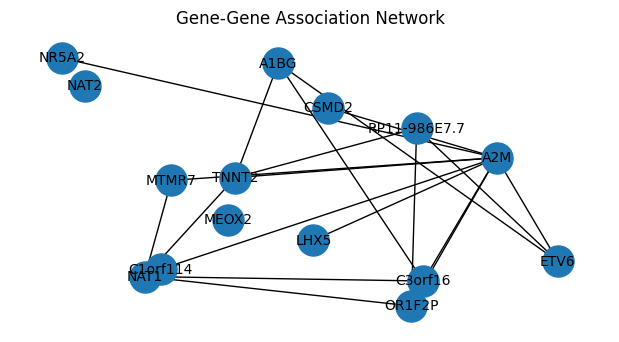

In [23]:
# Draw the network
plt.figure(figsize=(6, 3))
pos = nx.random_layout(G, seed=42)  # Layout for visualization
nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, font_color="black")
plt.title("Gene-Gene Association Network")
plt.show()

### Conclusion

This project demonstrates a complete workflow for integrating TCGA multi-omics data to infer gene–gene associations:  

1. Clinical, RNA-seq, and DNA methylation data were programmatically downloaded and processed.  
2. Data were standardized and a subset was used to illustrate the pipeline.  
3. LASSO regression identified sparse associations between methylation probes and gene expression.  
4. Significant associations were visualized as a network, highlighting potential regulatory relationships.

Overall, this approach showcases the use of computational methods and machine learning to extract biologically meaningful insights from large-scale multi-omics datasets, providing a foundation for further exploratory or hypothesis-driven analyses in cancer research.